In [3]:
import os
import re
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import xml.etree.ElementTree as ET
import json
import numpy as np
from xmltodict import parse
from collections import ChainMap

## Import Data

In [4]:
#'2022-02260 Requester Copy.xml' is from the FOIA request
raw_data = pd.read_xml('2022-02260 Requester Copy.xml',encoding='latin1')
chains = pd.read_csv('dinesafe 2019-04-08 chains.csv', encoding='latin-1', dtype={'Establishment ID':'int','Inspection ID':'int','Company/Franchise':'str','Name':'str','Type':'str','Address':'str','Lat':'float','Long':'float','Status':'str','Minimum inspections per year':'int','Infraction details':'str','Inspection date':'str','Severity':'str','Action':'str','Court outcome':'str','Amount fined':'float'})

In [5]:
len(raw_data['ESTABLISHMENT_ID'].unique())

36378

In [762]:
data = raw_data.fillna(0) #fill in NA values
data['INSPECTION_DATE']=pd.to_datetime(data['INSPECTION_DATE'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733495 entries, 0 to 733494
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   ROW_ID                       733495 non-null  int64         
 1   ESTABLISHMENT_ID             733495 non-null  int64         
 2   INSPECTION_ID                733495 non-null  int64         
 3   ESTABLISHMENT_NAME           733495 non-null  object        
 4   ESTABLISHMENTTYPE            733495 non-null  object        
 5   ESTABLISHMENT_ADDRESS        733495 non-null  object        
 6   LATITUDE                     733495 non-null  float64       
 7   LONGITUDE                    733495 non-null  float64       
 8   ESTABLISHMENT_STATUS         733495 non-null  object        
 9   MINIMUM_INSPECTIONS_PERYEAR  733495 non-null  float64       
 10  INFRACTION_DETAILS           733495 non-null  object        
 11  INSPECTION_DATE           

## Exploratory Data Analysis - Inspection frequency

In [763]:
first_insp = data.groupby('ESTABLISHMENT_ID')['INSPECTION_DATE'].min()
last_insp = data.groupby('ESTABLISHMENT_ID')['INSPECTION_DATE'].max()
#how many unique entities are there?
last_insp.count()

36378

<AxesSubplot:xlabel='INSPECTION_DATE', ylabel='Count'>

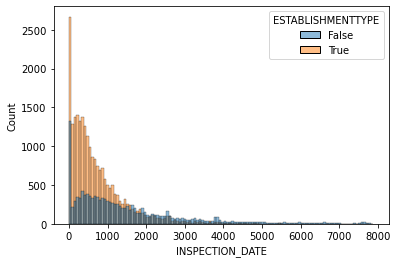

In [764]:
#plot of days between inspections
id_date_group = data.groupby(['ESTABLISHMENT_ID','INSPECTION_DATE'])
id_group = data.groupby(['ESTABLISHMENT_ID'])
#id_date_group['INSPECTION_DATE'].count().unique() #wow, who had 28 inspections?
#sns.histplot(id_date_group['DATE'].count()) #vast majority have only 1-2 inspections
date_range = id_group['INSPECTION_DATE'].max() - id_group['INSPECTION_DATE'].min()
days_per_insp = date_range/id_date_group['INSPECTION_DATE'].count()//pd.Timedelta('1 days') #average days between inspections
day_insp_type = pd.concat([(id_group['ESTABLISHMENTTYPE'].first().str.contains('Take out|Restaurant|food court',case=False)),days_per_insp.groupby('ESTABLISHMENT_ID').min()],axis='columns')
sns.histplot(day_insp_type,x='INSPECTION_DATE',hue='ESTABLISHMENTTYPE')

In [765]:
#how many had their last inspection within a year?
(last_insp>pd.to_datetime('2021-12-31',yearfirst=True)).sum()

14460

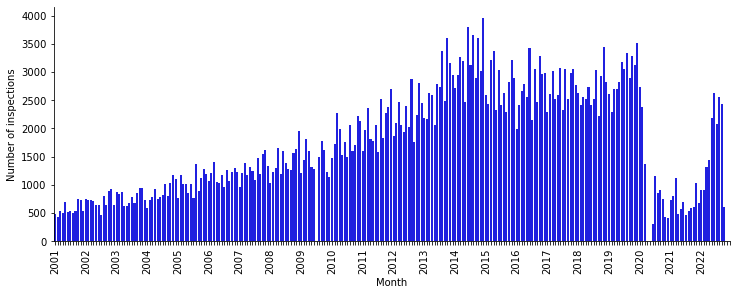

In [766]:
#plot inspections per month
unique_inspections=id_date_group.first()
monthly_inspections = unique_inspections.resample('M',origin='2017-01-01',level='INSPECTION_DATE').count()
monthly_inspections.sum()
inspections_frequency = sns.catplot(data=monthly_inspections.reset_index(),x='INSPECTION_DATE',y='ESTABLISHMENT_NAME',kind='bar',height=4,aspect=3,color='blue')
inspections_frequency.set(xlabel='Month',ylabel='Number of inspections',xticks=range(264))
for ax in inspections_frequency.axes.flat:
    labels = ax.get_xticklabels()
    labels_f = []
    month = 0
    for label in labels:
        if month %12 == 0:
            labels_f.append(pd.to_datetime(label.get_text()).strftime('%Y'))
        else: labels_f.append('')
        month += 1
    ax.set_xticklabels(labels_f, rotation=90) 

## Exploratory Data Analysis - Establishment Counts and Inspection Counts

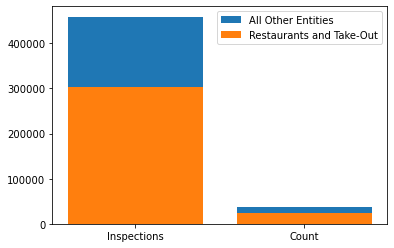

In [767]:
#count inspections for actual restaurants and takeout
is_restaurant = id_group.first()['ESTABLISHMENTTYPE'].str.contains('Food Take Out|Restaurant|Food Court')
resto_unique_inspections = unique_inspections.join(is_restaurant,rsuffix='.resto')
resto_unique_inspections = resto_unique_inspections.loc[resto_unique_inspections['ESTABLISHMENTTYPE.resto']==True,:]
#resto_unique_inspections.info()
#this one does it proportionally
#restaurant_types = pd.DataFrame([[resto_unique_inspections['INSPECTION_ID'].count()/unique_inspections['INSPECTION_ID'].count(),unique_inspections['INSPECTION_ID'].count()/unique_inspections['INSPECTION_ID'].count()],
#                                 [is_restaurant.sum()/last_insp.count(),last_insp.count()/last_insp.count()]],columns=['Restaurants and Take-out','All Entities'],index=['Inspections','Count'])
restaurant_types = pd.DataFrame([[resto_unique_inspections['INSPECTION_ID'].count(),unique_inspections['INSPECTION_ID'].count()],[is_restaurant.sum(),last_insp.count()]],columns=['Restaurants and Take-out','All Entities'],index=['Inspections','Count'])
plt.figure(figsize=(6,4))
dinesafe_composition = plt.bar(restaurant_types.index,restaurant_types.iloc[:,1])
plt.bar(restaurant_types.index,restaurant_types.iloc[:,0])
plt.legend(['All Other Entities','Restaurants and Take-Out'])

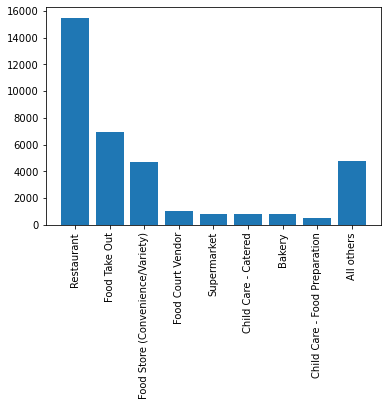

In [768]:
#plot count of establishment types
establishment_type_count = id_group.first().groupby('ESTABLISHMENTTYPE')['ESTABLISHMENT_NAME'].count().sort_values(ascending=False)
top8=pd.concat([establishment_type_count.iloc[0:8],pd.Series(establishment_type_count.iloc[9:].sum(),index=['All others'])]).rename('top8')

establishment_type_plot = plt.bar(top8.index,top8)
plt.tick_params(axis='x', rotation=90)

In [769]:
#check out these restaurants for testing:
#resto_unique_inspections.loc[resto_unique_inspections['ESTABLISHMENT_NAME'].str.contains('4c bro',case=False)==True,:]

## Exploratory Data Analysis - Restaurant Survival Curve

In [772]:
#how can we tell which restaurants have gone out of business?
#easy way: use status= out of business
#another way: use last inspection was before 2020
#another way: another restaurant has replaced it at the same address
out_of_business = resto_unique_inspections.loc[resto_unique_inspections['ESTABLISHMENT_STATUS'].str.contains('out of business',case=False)==True,:]
out_of_business.index.unique() #11584 entries
out_of_business.reset_index(level=1).index.unique #11584 entries
#same length, so there are no duplicates here - restaurants don't go out of business twice

<bound method Index.unique of Int64Index([ 1223438,  9000002,  9000029,  9000109,  9000145,  9000214,
             9000228,  9000265,  9000278,  9000286,
            ...
            10759065, 10759069, 10759216, 10759697, 10761364, 10761648,
            10761653, 10762366, 10764681, 10765468],
           dtype='int64', name='ESTABLISHMENT_ID', length=11584)>

<AxesSubplot:xlabel='INSPECTION_DATE.last', ylabel='Count'>

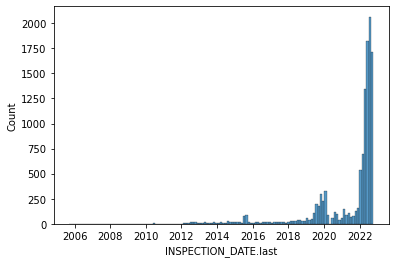

In [773]:
#now see the last inspections of restaurants are that still in business
unique_resto = id_group.last().loc[is_restaurant.loc[is_restaurant==True].index]
active_resto = unique_resto.drop(out_of_business.reset_index(level=1).index)
active_resto_last = active_resto.join(last_insp,rsuffix='.last')
sns.histplot(active_resto_last,x='INSPECTION_DATE.last')

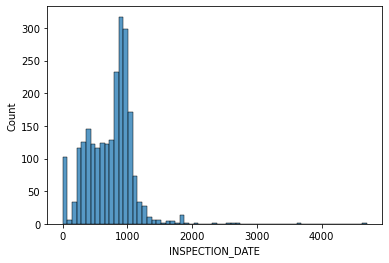

In [948]:
#how did time between inspections change with Covid?
#check two years before covid, excluding out-of-business during that time
date_range_2019 = data.loc[(data['INSPECTION_DATE']>pd.to_datetime('2017-12-31'))&(data['INSPECTION_DATE']<pd.to_datetime('2020-01-01'))&(data['ESTABLISHMENT_STATUS']!='Out of Business')].groupby('ESTABLISHMENT_ID')
insp_range_2019 = date_range_2019['INSPECTION_DATE'].max()-date_range_2019['INSPECTION_DATE'].min()
days_per_insp = insp_range_2019/date_range_2019['INSPECTION_DATE'].count()//pd.Timedelta('1 days') #average days between inspections
#inspection_period_2019 = sns.histplot(days_per_insp.loc[is_restaurant]) #all restaurants
#days_per_insp.median() #66
#now check post-covid, using the cohort of dead restaurants because we want to check if their inspection rate is significantly different
date_range_2020 = data.loc[(data['INSPECTION_DATE']>pd.to_datetime('2020-03-17'))&(data['ESTABLISHMENT_STATUS']=='Out of Business')].groupby('ESTABLISHMENT_ID')
last_insp_precovid = data.loc[data['INSPECTION_DATE']<=pd.to_datetime('2020-03-17')].groupby('ESTABLISHMENT_ID')['INSPECTION_DATE'].last()

#for the ones with only one inspection, use the last pre-covid inspection date
one_insp_covid = date_range_2020['INSPECTION_DATE'].count() == 1
#list of those with multiple covid inspections 108
mult_insp_covid = one_insp_covid.loc[one_insp_covid==False] #108
#3033 list of previous inspection prior to covid 3033 should be 3173 - new restaurants
last_insp_precovid = last_insp_precovid.reset_index().loc[last_insp_precovid.reset_index()['ESTABLISHMENT_ID'].isin(one_insp_covid.reset_index()['ESTABLISHMENT_ID'])].set_index('ESTABLISHMENT_ID')
date_range_one_insp = pd.concat([last_insp_precovid['INSPECTION_DATE'],date_range_2020['INSPECTION_DATE'].first().loc[mult_insp_covid.index]])
insp_range_2020 = date_range_2020['INSPECTION_DATE'].max()-date_range_one_insp
days_per_insp = insp_range_2020/date_range_2020['INSPECTION_DATE'].count()//pd.Timedelta('1 days') #average days between inspections
inspection_period_2020 = sns.histplot(days_per_insp.loc[is_restaurant])
#so the majority had not been inspected in 2+ years

#days_per_insp.median() #0 - most have been inspected only once in the years since in the almost 3 years - so it's hard to tell
#days_per_insp.count() #14904 vs 19507 out of 26000 total and 10901 active

1051 inspected before 2019, 10901 inspected during and after 2019


<AxesSubplot:xlabel='INSPECTION_DATE.last', ylabel='Count'>

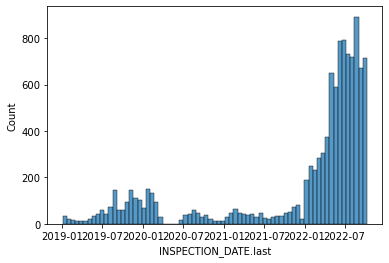

In [775]:
#the majority were last inspected in 2022, but a number still haven't been inspected starting in 2019
#so let's just assume that anything last inspected before 2019 has gone out of business
before_2019 = active_resto_last['INSPECTION_DATE.last']<pd.to_datetime('2019-01-01')
print('{} inspected before 2019, {} inspected during and after 2019'.format(before_2019.sum(),active_resto_last['INSPECTION_DATE.last'].count()-before_2019.sum()))
#add these businesses to the out-of-business list
out_of_business = pd.concat([out_of_business.reset_index()['ESTABLISHMENT_ID'],before_2019.loc[before_2019==True].reset_index()['ESTABLISHMENT_ID']]).reset_index(drop=True)
#and check the remainder
active_resto = unique_resto.drop(out_of_business)
active_resto_last = active_resto.join(last_insp,rsuffix='.last')
sns.histplot(active_resto_last,x='INSPECTION_DATE.last')

In [776]:
#great, now see if anything on the remaining active restaurant list has been replaced
#we want to check if the following conditions are true:
#1: another restaurant is at the same address
#2: it is not part of a food court
#3: the second restaurant has its first inspection after the first restaurant has its last inspection

#let's start with #1: check if the address is shared
shared_or_replaced = active_resto.groupby('ESTABLISHMENT_ADDRESS').count()
shared_or_replaced = shared_or_replaced.loc[shared_or_replaced['ESTABLISHMENT_NAME']>1] #about 1100 restaurants
#now check #2: 
#let's assume that if the address was shared in 2017 and 2018, then it is a shared location. this might include very high turnover locations
#shared addresses in 2017
food_courts_2017 = resto_unique_inspections.reset_index(level=1)
food_courts_2017 = food_courts_2017.loc[(food_courts_2017['INSPECTION_DATE']<pd.to_datetime('2018-01-01')) & (food_courts_2017['INSPECTION_DATE']>=pd.to_datetime('2017-01-01'))]
food_courts_2017 = food_courts_2017.groupby('ESTABLISHMENT_ADDRESS').count()
food_courts_2017 = food_courts_2017.loc[food_courts_2017['ESTABLISHMENT_NAME']>1]
#shared addresses in 2018
food_courts_2018 = resto_unique_inspections.reset_index(level=1)
food_courts_2018 = food_courts_2018.loc[(food_courts_2018['INSPECTION_DATE']<pd.to_datetime('2019-01-01')) & (food_courts_2018['INSPECTION_DATE']>=pd.to_datetime('2018-01-01'))]
food_courts_2018 = food_courts_2018.groupby('ESTABLISHMENT_ADDRESS').count()
food_courts_2018 = food_courts_2018.loc[food_courts_2018['ESTABLISHMENT_NAME']>1]
#shared addresses in both years
food_courts = food_courts_2018.loc[food_courts_2018.index.isin(food_courts_2017.index)]
#drop addresses from food courts
shared = shared_or_replaced.index.isin(food_courts.index)
replaced = shared_or_replaced.loc[~shared] #220 rows

#now we have a list of restaurants that may have been replaced
#let's drop anything with more than two restaurants registered at the address, because a random validation indicates that they are new food courts
replaced = replaced.loc[replaced['ROW_ID']<3]

#let's now tackle #3: first inspection and last inspection do not overlap
overlap_resto = active_resto.join(replaced,on='ESTABLISHMENT_ADDRESS',how='right',rsuffix='.r')
#add column showing ID of restaurant sharing the location with them
overlap_resto = pd.concat([overlap_resto.reset_index().groupby('ESTABLISHMENT_ADDRESS').first()['ESTABLISHMENT_ID'].rename('first'),
                           overlap_resto.reset_index().groupby('ESTABLISHMENT_ADDRESS').last()['ESTABLISHMENT_ID'].rename('last')],axis='columns')
overlap_resto = pd.concat([overlap_resto.join(first_insp,on='first',rsuffix='.first').rename(columns={'INSPECTION_DATE':'first_insp1'}),
                           overlap_resto.join(last_insp,on='first',rsuffix='.first').rename(columns={'INSPECTION_DATE':'first_insp2'})['first_insp2'],
                           overlap_resto.join(first_insp,on='last',rsuffix='.first').rename(columns={'INSPECTION_DATE':'last_insp1'})['last_insp1'],
                           overlap_resto.join(last_insp,on='last',rsuffix='.first').rename(columns={'INSPECTION_DATE':'last_insp2'})['last_insp2']],axis='columns')
#find non-overlapping restaurants:
replaced = overlap_resto.loc[overlap_resto['last_insp1']>overlap_resto['first_insp2']]
replaced['first'] #71 replaced

ESTABLISHMENT_ADDRESS
1006 DUNDAS ST W        10671237
1010 WILSON AVE         10727501
1086 ISLINGTON AVE      10677030
1120 MARTIN GROVE RD    10274551
124 BELFIELD RD          9003274
                          ...   
78 GERRARD ST W         10724171
799 BRIMLEY RD          10518927
852 WILSON AVE          10537577
881 ST CLAIR AVE W      10635548
971 KINGSTON RD         10406629
Name: first, Length: 71, dtype: int64

In [777]:
out_of_business = pd.concat([out_of_business,replaced['first']]).reset_index(drop=True)
#great, so now we have a list of dead restaurants about 16,000 long
#let's plot their lifespans: time between first and last inspection

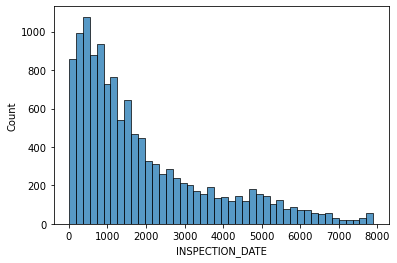

In [778]:
lifespans_dead = last_insp[out_of_business]-first_insp[out_of_business]
#don't forget that currently-alive restaurants have a lifespan as well, this is just a list of dead restaurants
#have to convert it to days otherwise run out of memory trying to hist nanoseconds
lifespans_dead_plot = sns.histplot(lifespans_dead.dt.days)
#okay, but this is a histogram of lifespans, we need to convert it to a cumulative survival curve
#day 0 is the sum of all restaurants with lifespan >0, day 1000 is the sum of all restaurants with lifespan > 1000, etc
survival_curve_base = []
for x in range(8000): 
    survival_curve_base.append([x,lifespans_dead.loc[lifespans_dead.dt.days>x].count()])
survival_curve_base = pd.DataFrame(survival_curve_base)

0.869894465479739

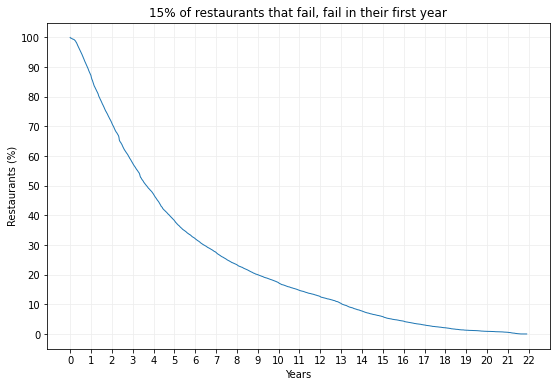

In [779]:
survival_curve_base = survival_curve_base.rename({0:'Days',1:'Restaurants'},axis='columns')
fig, survival_plot = plt.subplots(figsize=(9,6))
survival_plot.set(xlabel='Years',ylabel='Restaurants (%)',title='15% of restaurants that fail, fail in their first year',xticks=range(23),yticks=np.multiply(range(11),10))
survival_plot.plot(survival_curve_base['Days']/365.25,survival_curve_base['Restaurants']/survival_curve_base['Restaurants'].max()*100,linewidth=1.0)
survival_plot.grid(color='#eeeeee')
survival_curve_base.loc[365,'Restaurants']/survival_curve_base['Restaurants'].max()

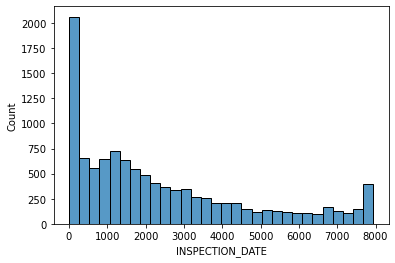

In [780]:
#how long have currently-alive restaurants lasted for?
out_of_business = out_of_business.rename('out_of_business')
is_restaurant.loc[is_restaurant==True].reset_index()['ESTABLISHMENT_ID'].isin(out_of_business.rename('out_of_business'))
#12120 True... but should be 16159
out_of_business.isin(is_restaurant.index).sum() #16159 as expected
in_business = is_restaurant.loc[is_restaurant==True]
in_business = in_business.drop(out_of_business) #22451->10331 after drop, losing 12120 businesses. not 16159.
#so what is not being counted?
out_of_business.duplicated().sum() #4039 are duplicated, explaining the discrepancy
lifespans_alive = last_insp[in_business.index]-first_insp[in_business.index]
#don't forget that currently-alive restaurants have a lifespan as well, this is just a list of dead restaurants
#have to convert it to days otherwise run out of memory trying to hist nanoseconds
lifespans_alive_plot = sns.histplot(lifespans_alive.dt.days)

0.9099989260015036

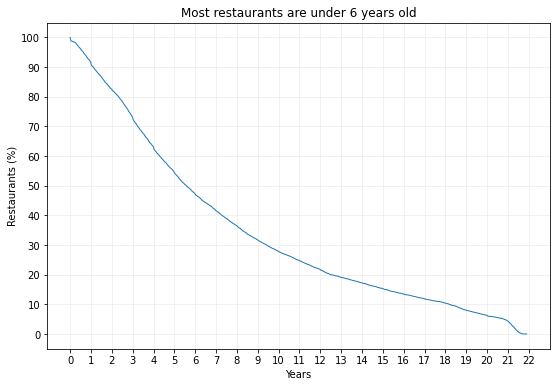

In [781]:
#so some have lasted the whole length of the dataset - still alive!
#let's add them to the survival curve
#plot the number of active restaurants by age to determine our cutoff for long-term survivors
age_curve = []
for x in range(8000): 
    age_curve.append([x,lifespans_alive.loc[lifespans_alive.dt.days>x].count()])
age_curve = pd.DataFrame(age_curve)
age_curve = age_curve.rename({0:'Days',1:'Restaurants'},axis='columns')
fig, age_plot = plt.subplots(figsize=(9,6))
age_plot.set(xlabel='Years',ylabel='Restaurants (%)',title='Most restaurants are under 6 years old',xticks=range(23),yticks=np.multiply(range(11),10))
age_plot.plot(age_curve['Days']/365.25,age_curve['Restaurants']/age_curve['Restaurants'].max()*100,linewidth=1.0)
age_plot.grid(color='#eeeeee')
age_curve.loc[365,'Restaurants']/age_curve['Restaurants'].max()

In [782]:
#so the bend seems to be at 21 years = 7665 days
age_curve.loc[365*21,'Restaurants']
#there are 388 restaurants that have survived up to 21 years - so add that as the base of the survival curve

407

0.8422776911076443

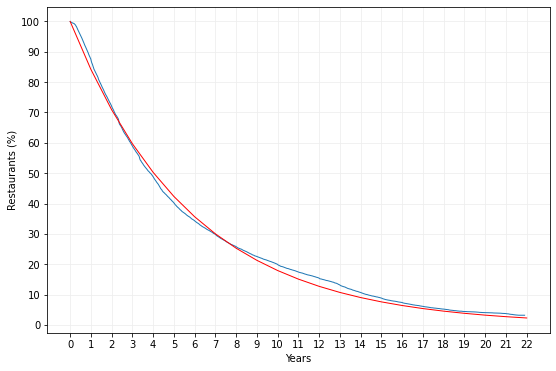

In [783]:
survival_curve_base = survival_curve_base.rename({0:'Days',1:'Restaurants'},axis='columns')
fig, survival_plot2 = plt.subplots(figsize=(9,6))
#title: 17% of restaurants fail in their first year
#title: Age doesn\'t matter much: chances of failure remain constant
survival_plot2.set(xlabel='Years',ylabel='Restaurants (%)',title='',xticks=range(23),yticks=np.multiply(range(11),10))
survival_plot2.plot(survival_curve_base['Days']/365.25,
                    (survival_curve_base['Restaurants']+age_curve.loc[365*21,'Restaurants'])
                    /(survival_curve_base['Restaurants'].max()+age_curve.loc[365*21,'Restaurants'])*100,
                    linewidth=1.0)
#let's try to fit a decay constant:
test_decay = []
half_life = 0.172
for x in range(23):
    test_decay.append(100*np.e ** (-x*half_life))
survival_plot2.plot(test_decay,color='red',linewidth=1.0)

survival_plot2.grid(color='#eeeeee')
survival_curve_base.loc[365,'Restaurants']/(survival_curve_base['Restaurants'].max()+age_curve.loc[365*21,'Restaurants'])

In [785]:
survival_curve_base.loc[survival_curve_base['Restaurants']>=(survival_curve_base.iloc[0,1]+age_curve.loc[365*21,'Restaurants'])/2,'Days'].max()
#the median lifetime of a restaurant is 3.5 years

1277

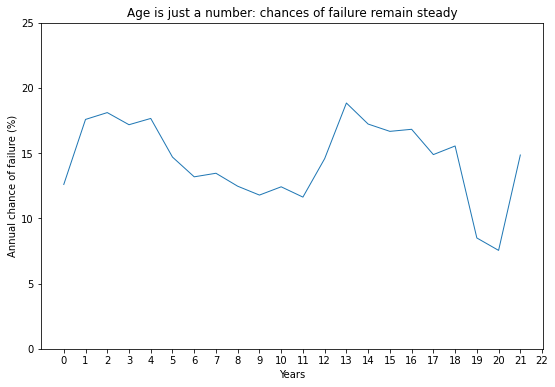

In [787]:
#plot chances of failure by age
yearly_survival=pd.DataFrame()
for x in range(23): 
    yearly_survival = pd.concat([yearly_survival,survival_curve_base.loc[survival_curve_base.loc[survival_curve_base['Days']<=(365*x)]['Days'].max()]])
yearly_survival = pd.concat([yearly_survival.reset_index().loc[yearly_survival.reset_index()['index']=='Days',0].reset_index(drop=True),
                             yearly_survival.reset_index().loc[yearly_survival.reset_index()['index']=='Restaurants',0].reset_index(drop=True)], axis='columns',ignore_index=True)
yearly_survival[1]=yearly_survival[1]+age_curve.loc[365*21,'Restaurants']
failure_rate=[]
for x in range(yearly_survival.shape[0]-1):
    failure_rate.append(100*(1-yearly_survival.iloc[x+1,1]/yearly_survival.iloc[x,1]))
fig, annual_failure_plot = plt.subplots(figsize=(9,6))
#title: Age is just a number: chances of failure remain steady
annual_failure_plot.set(xlabel='Years',ylabel='Annual chance of failure (%)',title='Age is just a number: chances of failure remain steady',xticks=range(23),ylim=(0,25),yticks=np.multiply(range(6),5))
annual_failure_plot.plot(failure_rate, linewidth=1.0)

In [ ]:
#Whether or not restaurant existed during Covid:
#start by removing duplicates...
out_of_business = out_of_business.loc[~out_of_business.duplicated()]
died_during_covid = (last_insp.loc[out_of_business] > pd.to_datetime('2020-03-17',yearfirst=True))
lifespans_dead_covid = lifespans_dead.loc[died_during_covid]
#see how that did

def survival_curve(criteria):
    lifespans_dead_criteria = lifespans_dead.loc[criteria]
    survival_curve = []
    for x in range(8000): 
        survival_curve.append([x,lifespans_dead_criteria.loc[lifespans_dead_criteria.dt.days>x].count()])
    survival_curve = pd.DataFrame(survival_curve)
    survival_curve = survival_curve.rename({0:'Days',1:'Restaurants'},axis='columns')
    return survival_curve
def survival_plot(survival_curve,color):
    fig, survival_plot = plt.subplots(figsize=(9,6))
    survival_plot.set(xlabel='Years',ylabel='Restaurants (%)',title='',xticks=range(23),yticks=np.multiply(range(11),10))
    survival_plot.plot(survival_curve['Days']/365.25,survival_curve['Restaurants']/survival_curve['Restaurants'].max()*100,linewidth=1.0,color=color)
    survival_plot.grid(color='#eeeeee')
    survival_curve.loc[365,'Restaurants']/survival_curve['Restaurants'].max()
covid_survival=survival_curve(died_during_covid)
survival_plot(covid_survival,'red')
survival_plot(survival_curve_base,'blue')
#restaurants that died during covid, what was their inspection period before then?

## Predictive Model - Feature Engineering

In [1463]:
#year
#Infraction count per year
#Conditional passes per year
#closures in a year
#existed during covid
#Part of a chain
#restaurant type - 3 exclusive categories
#Keywords in name - 21 keywords
#restaurant density in area
#two test values

#so I want to give the above inputs to a regression tool, and have it say whether or not the restaurant will fail in that year
#so the inputs would be the data grouped by restaurant ID and year
model_head = data.groupby(['ESTABLISHMENT_ID',pd.Grouper(key='INSPECTION_DATE',freq='Y')]).first()
#trim to restaurants only
model_head = model_head.reset_index(level=1).join(is_restaurant.loc[is_restaurant],rsuffix='.isresto',how='right').set_index('INSPECTION_DATE',append=True)

#test values: does restaurant survive this year or next 2 years
model_alive = model_head.reset_index(level=1).join(last_insp.rename('last_insp')).rename({'INSPECTION_DATE':'end_of_year'},axis='columns')
model_survive_1yr = model_alive['end_of_year'].dt.year != model_alive['last_insp'].dt.year #last inspection (death year) is this year - the death year
model_survive_1yr = pd.concat([model_survive_1yr,model_alive['end_of_year'].rename('INSPECTION_DATE')],axis='columns').set_index('INSPECTION_DATE',append=True)
model_survive_2yr = model_alive['end_of_year'].dt.year+1 < (model_alive['last_insp'].dt.year) #last inspection is next year or this year - dies within 2 years
model_survive_2yr = pd.concat([model_survive_2yr,model_alive['end_of_year'].rename('INSPECTION_DATE')],axis='columns').set_index('INSPECTION_DATE',append=True)

#infraction counts: id-date multiindex, count
model_i_sig = data.loc[data['SEVERITY']=='S - Significant'].groupby(['ESTABLISHMENT_ID',pd.Grouper(key='INSPECTION_DATE',freq='Y')])['SEVERITY'].count()
model_i_min = data.loc[data['SEVERITY']=='M - Minor'].groupby(['ESTABLISHMENT_ID',pd.Grouper(key='INSPECTION_DATE',freq='Y')])['SEVERITY'].count()
model_i_cru = data.loc[data['SEVERITY']=='C - Crucial'].groupby(['ESTABLISHMENT_ID',pd.Grouper(key='INSPECTION_DATE',freq='Y')])['SEVERITY'].count()

#conditional pass/closed counts: id-date multiindex, count -  - leaving out pass counts as that is correlated with conditional pass
model_stat_cond = data.loc[data['ESTABLISHMENT_STATUS']=='Conditional Pass'].groupby(['ESTABLISHMENT_ID',pd.Grouper(key='INSPECTION_DATE',freq='Y'),'INSPECTION_ID'])['ESTABLISHMENT_STATUS'].first().reset_index(level=2, drop=True)
model_stat_cond = model_stat_cond.groupby(['ESTABLISHMENT_ID','INSPECTION_DATE']).count()
model_stat_clos = data.loc[data['ESTABLISHMENT_STATUS']=='Closed'].groupby(['ESTABLISHMENT_ID',pd.Grouper(key='INSPECTION_DATE',freq='Y'),'INSPECTION_ID'])['ESTABLISHMENT_STATUS'].first().reset_index(level=2, drop=True)
model_stat_clos = model_stat_clos.groupby(['ESTABLISHMENT_ID','INSPECTION_DATE']).count()

#existed during covid
model_during_covid = pd.concat([died_during_covid.loc[died_during_covid==True],in_business]) #2495 + 10830 = 13325
model_during_covid = model_head.reset_index(level=1).loc[model_head.reset_index(level=1)['INSPECTION_DATE']>=pd.to_datetime('2020-12-31'),'INSPECTION_DATE']
model_during_covid = pd.concat([model_during_covid,model_during_covid.notna().rename('during_covid')],axis='columns').set_index('INSPECTION_DATE',append=True)
model_during_covid = pd.concat([model_head,model_during_covid]).fillna(False)['during_covid']

#Part of a chain
top_chains = chains.groupby('Company/Franchise').count().sort_values('Name',ascending=False).iloc[0:49]['Name'] #top 50 most prevalent chains
chain_member = chains.join(top_chains,on='Company/Franchise',rsuffix='.top')
chain_member = chain_member.loc[chain_member['Name.top'].notna(),'Establishment ID']
model_chain = data.loc[data['ESTABLISHMENT_ID'].isin(chain_member)].groupby(['ESTABLISHMENT_ID','INSPECTION_DATE'])['ESTABLISHMENT_NAME'].first().astype('bool')
model_chain = model_head.reset_index(level=1).join(model_chain.reset_index(level=1),rsuffix='.chain').loc[:,['INSPECTION_DATE','ESTABLISHMENT_NAME.chain']].fillna('False').set_index('INSPECTION_DATE',append=True).rename({'ESTABLISHMENT_NAME.chain':'ischain'},axis='columns')

#restaurant type - one-hot encoding
model_type_takeout = model_head['ESTABLISHMENTTYPE'].str.contains('Food Take Out',case=False)
model_type_resto = model_head['ESTABLISHMENTTYPE'].str.contains('Restaurant',case=False)
model_type_foodcourt = model_head['ESTABLISHMENTTYPE'].str.contains('Food Court',case=False)

#name keywords
name_kw = {0:'pho',1:'shawarma',2:'pizza',3:'coffee',4:'grill',5:'burger',6:'sushi',7:'tea',8:'teriyaki',9:'fries',10:'wok',11:'chinese',
          12:'pub',13:'wing',14:'thai',15:'indian',16:'japanese',17:'bagel',18:'burrito',19:'vegan',20:'donut'}
model_names = pd.DataFrame()
for x in name_kw:
    model_names = pd.concat([model_names,model_head['ESTABLISHMENT_NAME'].str.contains(name_kw[x],case=False)],axis='columns')
model_names.columns=['kw_pho','kw_shawarma','kw_pizza','kw_coffee','kw_grill','kw_burger','kw_sushi','kw_tea','kw_teriyaki','kw_fries',
                         'kw_wok','kw_chinese','kw_pub','kw_wing','kw_thai','kw_indian','kw_japanese','kw_bagel','kw_burrito','kw_vegan',
                        'kw_donut']

#restaurant density is in next panel because it takes forever


In [ ]:
#restaurant density - # of neighbours within x radius
import geopandas as gpd
#need to get list of restaurants active at the same time

gpd_density = gpd.GeoDataFrame(unique_resto, geometry=gpd.points_from_xy(unique_resto['LONGITUDE'],unique_resto['LATITUDE']))
gpd_density.crs = {'init': 'epsg:4326'}
bufferdist=[100,500,1000] #buffer distances

#this takes 2 hours to run per year - let's just do it for 100m, be careful about running this
neighbour_count = []
gpd_density_buffers=gpd_density['geometry'].to_crs(crs=3857).buffer(bufferdist[0])
for year in model_head.reset_index()['INSPECTION_DATE'].unique():
    if ((np.datetime64(year,'Y').astype('int')+1970) %4) == 0: #only do every 4 years... assume it's relatively stationary over that time
        neighbours_id = model_survive_1yr.reset_index().loc[model_survive_1yr.reset_index()['INSPECTION_DATE']==year]
        gpd_neighbours = gpd_density.loc[neighbours_id['ESTABLISHMENT_ID']]
        print('working on: '+str(year))
        buffer_row = 0
        for restaurant_buffer in gpd_density_buffers:
            restaurant_count = 0
            for neighbour in gpd_neighbours['geometry'].to_crs(crs=3857):
                if restaurant_buffer.contains(neighbour): restaurant_count += 1
            neighbour_count.append([bufferdist[0],year,restaurant_count])
            buffer_row += 1
            if ((buffer_row%1000) == 0): print('done:'+str(buffer_row))

In [ ]:
#process neighbour data into a list that corresponds to the model_head format
buffer_index=pd.DataFrame()
#i did every restaurant for every year, including restaurants that didn't exist in that year, that was silly
#the advantage is it's easy to recreate the index
for year in model_head.reset_index()['INSPECTION_DATE'].unique():
    neighbours_id = model_survive_1yr.reset_index().loc[model_survive_1yr.reset_index()['INSPECTION_DATE']==year]
    gpd_neighbours = gpd_density.loc[neighbours_id['ESTABLISHMENT_ID']]
    buffer_index = pd.concat([buffer_index,gpd_neighbours.reset_index()])
neighbour_data = pd.DataFrame(neighbour_count,columns=['buffer','year','neighbours_within_buffer'])
model_neighbours = pd.DataFrame()
refyear = pd.to_datetime('2004-12-31') #first reference date to centre around
for year in model_head.reset_index()['INSPECTION_DATE'].unique():
    if ((np.datetime64(year,'Y').astype('int')+1970)%4) ==0: refyear = year #03-05 will ref 2004, 06-09 will ref 2008, etc.
    year_data = neighbour_data.loc[neighbour_data['year']==refyear]
    model_neighbours = pd.concat([model_neighbours,year_data])
#model_neighbours = pd.concat([buffer_index,model_neighbours],axis='columns')

In [1427]:
#buffer_index['ESTABLISHMENT_ID']
#assign index to neighbour_data
modelyear = []
for x in range(21):
    tempyear = 2003+x
    stryear = str(tempyear)+'-12-31'
    for x in range(23520): modelyear.append(pd.to_datetime(stryear))
modelyear = pd.Series(modelyear, name='end_of_year')
model_neighbourcount = pd.DataFrame()
bufferlength = gpd_density_buffers.shape[0]

#join the index to the data
model_neighbourcount = pd.DataFrame()
for x in range(21):
    temp_neighbours = pd.concat([gpd_density_buffers.reset_index().iloc[:,0],
                                 model_neighbours.iloc[bufferlength*x:bufferlength*(x+1)].reset_index(drop=True)],axis='columns')
    model_neighbourcount = pd.concat([model_neighbourcount,temp_neighbours])
model_neighbourcount = pd.concat([model_neighbourcount.reset_index(drop=True),modelyear],axis='columns')
model_neighbourcount_100 = model_neighbourcount.rename({'end_of_year':'INSPECTION_DATE'},axis='columns').set_index(['ESTABLISHMENT_ID','INSPECTION_DATE']).drop(['buffer','year'],axis='columns')
model_neighbourcount_100=model_neighbourcount_100['neighbours_within_buffer'].subtract(1) #take out their own intersection

0        2003-12-31
1        2003-12-31
2        2003-12-31
3        2003-12-31
4        2003-12-31
            ...    
493915   2023-12-31
493916   2023-12-31
493917   2023-12-31
493918   2023-12-31
493919   2023-12-31
Name: end_of_year, Length: 493920, dtype: datetime64[ns]

In [1558]:
model_chain

ischain
ESTABLISHMENT_ID INSPECTION_DATE        
1222579          2003-12-31        False
                 2004-12-31        False
                 2005-12-31        False
                 2006-12-31        False
                 2007-12-31        False
...                                  ...
10765703         2022-12-31        False
10765721         2022-12-31        False
10765722         2022-12-31        False
10765737         2022-12-31        False
10765921         2022-12-31        False

[594907 rows x 1 columns]

In [1592]:
#put all the features together into model_head
model_clean = pd.concat([model_head.loc[:,'ESTABLISHMENT_NAME'],model_survive_1yr.rename({0:'survive_1yr'},axis=1),
                         model_survive_2yr.rename({0:'survive_2yr'},axis=1),model_i_sig.rename('infr_sig'),
                         model_i_min.rename('infr_min'),model_i_cru.rename('infr_cru'),
                         model_stat_cond.rename('stat_cond'),model_stat_clos.rename('stat_clos')],axis='columns')
model_clean = model_clean.dropna(subset=['ESTABLISHMENT_NAME']).fillna(0)
#more features
model_clean = pd.concat([model_clean,model_chain.reset_index().drop_duplicates().set_index(['ESTABLISHMENT_ID','INSPECTION_DATE']),
           model_type_takeout.rename('type_takeout'),model_type_resto.rename('type_resto'),model_type_foodcourt.rename('type_foodcourt'),
          model_names],axis='columns')
model_during_covid_clean = model_during_covid.reset_index().drop_duplicates(subset=['ESTABLISHMENT_ID','INSPECTION_DATE']).set_index(['ESTABLISHMENT_ID','INSPECTION_DATE'])
model_clean = pd.concat([model_clean,model_during_covid_clean],axis='columns')
#final one
model_neighbourcount_clean = model_neighbourcount_100.reset_index().drop_duplicates(subset=['ESTABLISHMENT_ID','INSPECTION_DATE']).set_index(['ESTABLISHMENT_ID','INSPECTION_DATE'])
model_neighbourcount_clean = model_neighbourcount_clean.loc[model_neighbourcount_clean.index.isin(model_clean.index)]
model_clean = pd.concat([model_clean,model_neighbourcount_clean],axis='columns').fillna(0)

In [1661]:
model_clean.to_csv('model_clean.csv')

## Predictive Model - Model specification

In [1662]:
pip install imblearn --user

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
from sklearn import preprocessing, set_config
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression, SelectFromModel, SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
#from imblearn.over_sampling import SMOTE
#from imblearn.pipeline import Pipeline
from scipy.stats import loguniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report

In [16]:
#model_clean = pd.read_csv('survival_model_clean.csv').set_index(['Unnamed: 0','Unnamed: 1'])
#importing cleaned model because running the above takes too long
model_clean.columns
model_clean = model_clean.replace([True,False],[1,0])
model_clean = model_clean.replace(['True','False'],[1,0])

C:\Users\BrantZeeman\AppData\Local\Temp\ipykernel_17064\1910913720.py:1: DtypeWarning: Columns (14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  model_clean = pd.read_csv('survival_model_clean.csv').set_index(['Unnamed: 0','Unnamed: 1'])


In [18]:
scaler = MinMaxScaler()
model_scaled = model_clean.drop(['ESTABLISHMENT_NAME','survive_1yr','survive_2yr'],axis=1).loc[model_clean['during_covid']==False]
scaler.fit(model_scaled)
y=model_clean['survive_1yr']
X=scaler.transform(model_scaled)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=12345)
model = LogisticRegression(class_weight = 'balanced',max_iter=1000, penalty='l2')
model.fit(X_train,y_train)
f1_score(model.predict(X_train), y_train)

0.6708103573933252

In [19]:
model_scaled

infr_sig  infr_min  infr_cru  stat_cond  stat_clos  \
Unnamed: 0 Unnamed: 1                                                       
1222579    2003-12-31       2.0       2.0       0.0        1.0        0.0   
           2004-12-31       1.0       7.0       0.0        0.0        0.0   
           2005-12-31       0.0       2.0       0.0        0.0        0.0   
           2006-12-31       1.0       3.0       0.0        0.0        0.0   
           2007-12-31       2.0       3.0       0.0        1.0        0.0   
...                         ...       ...       ...        ...        ...   
10765703   2022-12-31       6.0       2.0       1.0        1.0        0.0   
10765721   2022-12-31       0.0       0.0       0.0        0.0        0.0   
10765722   2022-12-31       0.0       0.0       0.0        0.0        0.0   
10765737   2022-12-31       0.0       0.0       0.0        0.0        0.0   
10765921   2022-12-31       1.0       0.0       0.0        0.0        0.0   

                       ischain  type_takeout  type_resto  type_foodcourt  \
Unnamed: 0 Unnamed: 1                                                      
1222579    2003-12-31        0             1           0               0   
           2004-12-31        0             1           0               0   
           2005-12-31        0             1           0               0   
           2006-12-31        0             1           0               0   
           2007-12-31        0             1           0               0   
...                        ...           ...         ...             ...   
10765703   2022-12-31        0             0           1               0   
10765721   2022-12-31        0             1           0               0   
10765722   2022-12-31        0             1           0               0   
10765737   2022-12-31        0             0           1               0   
10765921   2022-12-31        0             1           0               0   

                      kw_pho  ... kw_wing kw_thai kw_indian kw_japanese  \
Unnamed: 0 Unnamed: 1         ...                                         
1222579    2003-12-31      0  ...       0       0         0           0   
           2004-12-31      0  ...       0       0         0           0   
           2005-12-31      0  ...       0       0         0           0   
           2006-12-31      0  ...       0       0         0           0   
           2007-12-31      0  ...       0       0         0           0   
...                      ...  ...     ...     ...       ...         ...   
10765703   2022-12-31      0  ...       0       0         0           0   
10765721   2022-12-31      0  ...       0       0         0           0   
10765722   2022-12-31      0  ...       0       0         0           0   
10765737   2022-12-31      0  ...       0       0         0           0   
10765921   2022-12-31      0  ...       0       0         0           0   

                      kw_bagel kw_burrito kw_vegan kw_donut during_covid  \
Unnamed: 0 Unnamed: 1                                                      
1222579    2003-12-31        0          0        0        0            0   
           2004-12-31        0          0        0        0            0   
           2005-12-31        0          0        0        0            0   
           2006-12-31        0          0        0        0            0   
           2007-12-31        0          0        0        0            0   
...                        ...        ...      ...      ...          ...   
10765703   2022-12-31        0          0        0        0            0   
10765721   2022-12-31        0          0        0        0            0   
10765722   2022-12-31        0          0        0        0            0   
10765737   2022-12-31        0          0        0        0            0   
10765921   2022-12-31        0          0        0        0            0   

                      neighbours_within_buffer  
Unnamed: 0 Unnamed

              precision    recall  f1-score   support

           0       0.23      0.73      0.35     17687
           1       0.91      0.53      0.67     91799

    accuracy                           0.56    109486
   macro avg       0.57      0.63      0.51    109486
weighted avg       0.80      0.56      0.62    109486

f_score = 0.6708103573933252


C:\Users\BrantZeeman\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


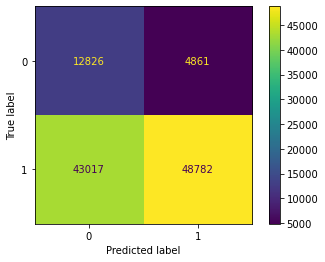

In [20]:
print(classification_report(y_train, model.predict(X_train)))
plot_confusion_matrix(model,X_train,y_train)
print(f'f_score = {f1_score(y_train, model.predict(X_train))}')

In [1704]:
model.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

# Hyperparameter Tuning

In [ ]:
param_grid = [   
    {
    'penalty' : ['l2','none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]
model2 = RandomizedSearchCV(model, param_distributions = param_grid, scoring='f1', n_iter=20, verbose=False)
best_model = model2.fit(X_train,y_train)

In [1716]:
best_model.best_score_

0.7928088568077893

              precision    recall  f1-score   support

           0       0.20      0.35      0.25     17687
           1       0.85      0.74      0.79     91799

    accuracy                           0.67    109486
   macro avg       0.53      0.54      0.52    109486
weighted avg       0.75      0.67      0.70    109486

f_score = 0.7900146327187592


C:\Users\BrantZeeman\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


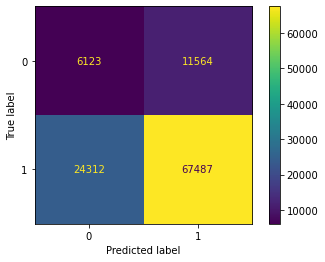

In [1717]:
print(classification_report(y_train, best_model.predict(X_train)))
plot_confusion_matrix(best_model,X_train,y_train)
print(f'f_score = {f1_score(y_train, best_model.predict(X_train))}')

In [22]:
final_model = LogisticRegression(C=0.00026366508987303583, class_weight='balanced',
                   max_iter=2500)

              precision    recall  f1-score   support

           0       0.20      0.34      0.25      5833
           1       0.85      0.74      0.79     30663

    accuracy                           0.68     36496
   macro avg       0.53      0.54      0.52     36496
weighted avg       0.75      0.68      0.71     36496

f_score = 0.7938542121344391


C:\Users\BrantZeeman\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


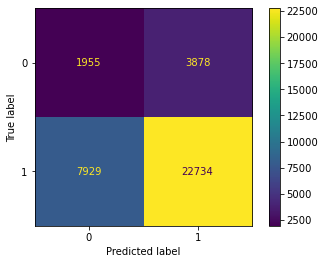

In [26]:
final_model.fit(X_train,y_train)

print(classification_report(y_test, final_model.predict(X_test)))
plot_confusion_matrix(final_model,X_test,y_test)
print(f'f_score = {f1_score(y_test, final_model.predict(X_test))}')

In [24]:
model_clean.drop(['ESTABLISHMENT_NAME','survive_1yr','survive_2yr'],axis=1).columns

Index(['infr_sig', 'infr_min', 'infr_cru', 'stat_cond', 'stat_clos', 'ischain',
       'type_takeout', 'type_resto', 'type_foodcourt', 'kw_pho', 'kw_shawarma',
       'kw_pizza', 'kw_coffee', 'kw_grill', 'kw_burger', 'kw_sushi', 'kw_tea',
       'kw_teriyaki', 'kw_fries', 'kw_wok', 'kw_chinese', 'kw_pub', 'kw_wing',
       'kw_thai', 'kw_indian', 'kw_japanese', 'kw_bagel', 'kw_burrito',
       'kw_vegan', 'kw_donut', 'during_covid', 'neighbours_within_buffer'],
      dtype='object')

In [25]:
final_model.coef_
#highest weights are sig infractions, ischain, minor infractions, is takeout, is resto

array([[ 1.20804997e-01,  2.02419420e-01,  2.65715454e-02,
         8.74350400e-02,  1.50493711e-03,  2.69552244e-01,
        -9.41477017e-02,  7.14532349e-02,  2.26995871e-02,
         3.53397130e-03, -1.37713988e-02,  3.93963803e-02,
         8.77904630e-05,  1.45274727e-02, -2.37404635e-02,
        -6.01738907e-03, -2.49078122e-02,  2.98728525e-03,
        -2.08277429e-03,  1.22354652e-02,  1.69696165e-02,
         1.69032457e-02, -3.25276985e-03, -4.04332387e-03,
        -5.25609536e-04,  1.03033338e-02,  1.76136893e-02,
        -1.11611300e-02, -1.08595847e-03,  1.17507993e-02,
         0.00000000e+00, -2.24333371e-02]])